# Описание задачи

Соревнование представляет собой увлекательный и практически важный опыт, ориентированный на студентов курса Data Science. Участникам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются. Соревнование проводится на популярной платформе Kaggle, что позволяет участникам не только применять на практике свои знания в области анализа данных и машинного обучения, но и освоить работу с этой платформой.

## В ходе работы мы пройдем все основные этапы полноценного исследования:

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

## Загрузка и ознакомление с данными

In [8]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Библиотеки для работы с моделями машинного обучения
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, RandomizedSearchCV, HalvingRandomSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from scipy.stats import randint, uniform
from tqdm import tqdm
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import lightgbm as lgb

# Модели машинного обучения
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
!pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Для анализа мультиколлинеарности
!pip install phik
import phik

# Для анализа важности признаков (SHAP)
import shap

# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

# Установка стиля для графиков
sns.set(style="whitegrid")

# Библиотека для обработки времени
from datetime import datetime

In [9]:
# Загрузим датасеты
train_df = pd.read_csv('kaggle_startups_train_28062024.csv') #Обучающие данные
test_df = pd.read_csv('kaggle_startups_test_28062024.csv') #Тестовые данные
kaggle_startups_sample_submit_01 = pd.read_csv('kaggle_startups_sample_submit_28062024.csv') #файл с примером предсказаний в правильном формате

#  Предварительная обработка

In [10]:
# Посмотрим на обучающие и тестовые данные и проверим правильность типов данных
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):

In [11]:
train_df

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaN
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaN
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaN
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaN


In [12]:
test_df

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267
13121,GlobaTrek,Software,NaN,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386


In [13]:
# Преобразуем в тренировочной выборке столбцы founded_at, first_funding_at, last_funding_at, closed_at в формат datetime

train_df['founded_at'] = pd.to_datetime(train_df['founded_at'], errors='coerce')
train_df['first_funding_at'] = pd.to_datetime(train_df['first_funding_at'], errors='coerce')
train_df['last_funding_at'] = pd.to_datetime(train_df['last_funding_at'], errors='coerce')
train_df['closed_at'] = pd.to_datetime(train_df['closed_at'], errors='coerce')

# Проверим изменения, просмотрим информацию о наборе данных после преобразования
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [14]:
# Преобразуем в тестовой выборке столбцы first_funding_at, last_funding_at в формат datetime

test_df['first_funding_at'] = pd.to_datetime(train_df['first_funding_at'], errors='coerce')
test_df['last_funding_at'] = pd.to_datetime(train_df['last_funding_at'], errors='coerce')

# Проверим изменения, просмотрим информацию о наборе данных после преобразования
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


In [15]:
# Посчитаем наличие пропусков в каждом столбце тренировочной выборки
train_df.isna().sum()

,0
name,1
category_list,2465
funding_total_usd,10069
status,0
country_code,5502
state_code,6763
region,6359
city,6359
funding_rounds,0
founded_at,0


In [16]:
# Заполняем пропуски в funding_total_usd медианой
train_df['funding_total_usd'].fillna(train_df['funding_total_usd'].median(), inplace=True)

# Заполняем пропуски в категориальных столбцах значением 'Unknown'
train_df['category_list'].fillna('Unknown', inplace=True)
train_df['country_code'].fillna('Unknown', inplace=True)
train_df['state_code'].fillna('Unknown', inplace=True)
train_df['region'].fillna('Unknown', inplace=True)
train_df['city'].fillna('Unknown', inplace=True)
train_df['name'].fillna('Unknown', inplace=True)

# Пропуски в 'closed_at' оставляем без изменений, так как это важный признак
train_df.isna().sum()

,0
name,0
category_list,0
funding_total_usd,0
status,0
country_code,0
state_code,0
region,0
city,0
funding_rounds,0
founded_at,0


In [17]:
# Посчитаем наличие пропусков в каждом столбце тестовой выборки
test_df.isna().sum()

,0
name,0
category_list,591
funding_total_usd,2578
country_code,1382
state_code,1695
region,1589
city,1587
funding_rounds,0
first_funding_at,0
last_funding_at,0


In [18]:
# Заполняем пропуски в funding_total_usd медианой
test_df['funding_total_usd'].fillna(test_df['funding_total_usd'].median(), inplace=True)

# Заполняем пропуски в категориальных столбцах значением 'Unknown'
test_df['category_list'].fillna('Unknown', inplace=True)
test_df['country_code'].fillna('Unknown', inplace=True)
test_df['state_code'].fillna('Unknown', inplace=True)
test_df['region'].fillna('Unknown', inplace=True)
test_df['city'].fillna('Unknown', inplace=True)

test_df.isna().sum()

,0
name,0
category_list,0
funding_total_usd,0
country_code,0
state_code,0
region,0
city,0
funding_rounds,0
first_funding_at,0
last_funding_at,0


In [19]:
# Проверим наличие полных дубликатов в тренировочной выборке
duplicate_rows = train_df[train_df.duplicated()]

# Проверим наличие дубликатов по полю 'name'
name_duplicates = train_df[train_df.duplicated(subset=['name'])]

# Выведем количество дубликатов
print(f"Количество полных дубликатов: {len(duplicate_rows)}")
print(f"Количество дубликатов по имени: {len(name_duplicates)}")

# Выведем сами дубликаты, если они есть
duplicate_rows.head(), name_duplicates.head()

Количество полных дубликатов: 0
Количество дубликатов по имени: 0


(Empty DataFrame
 Columns: [name, category_list, funding_total_usd, status, country_code, state_code, region, city, funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at]
 Index: [],
 Empty DataFrame
 Columns: [name, category_list, funding_total_usd, status, country_code, state_code, region, city, funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at]
 Index: [])

In [20]:
# Проверим наличие полных дубликатов в тестовой выборке
duplicate_rows = test_df[test_df.duplicated()]

# Проверим наличие дубликатов по полю 'name'
name_duplicates = test_df[test_df.duplicated(subset=['name'])]

# Выведем количество дубликатов
print(f"Количество полных дубликатов: {len(duplicate_rows)}")
print(f"Количество дубликатов по имени: {len(name_duplicates)}")

# Выведем сами дубликаты, если они есть
duplicate_rows.head(), name_duplicates.head()

Количество полных дубликатов: 0
Количество дубликатов по имени: 0


(Empty DataFrame
 Columns: [name, category_list, funding_total_usd, country_code, state_code, region, city, funding_rounds, first_funding_at, last_funding_at, lifetime]
 Index: [],
 Empty DataFrame
 Columns: [name, category_list, funding_total_usd, country_code, state_code, region, city, funding_rounds, first_funding_at, last_funding_at, lifetime]
 Index: [])

In [21]:
# посчитаем количество уникальных значений столбца category_list в тренировочной выборке
train_df['category_list'].nunique()

22106

In [22]:
# посчитаем количество уникальных значений столбца category_list в тестовой выборке
test_df['category_list'].nunique()

6207

Судя по кол-ву уникальных значений и формату их написания, в столбце множество неявных дубликатов. Попробуем устранить их с помощью словаря, который был создан Chat GPT, разделив столбец по "I" и проанализировав уникальные значения.

In [23]:
# Загрузим словарь категорий
category_rules_df   = pd.read_csv('category_rules.csv')

category_rules_df

,Category,Keyword
0,Technology and IT,software
1,Technology and IT,internet
2,Technology and IT,AI
3,Technology and IT,big data
4,Technology and IT,analytics
...,...,...
330,Organic Food and Goods,agriculture
331,Organic Food and Goods,market
332,Undefined,unknown
333,Undefined,not specified


In [24]:
# Преобразование DataFrame в словарь с категориями и ключевыми словами
category_rules = {}
for category in category_rules_df['Category'].unique():
    keywords = category_rules_df[category_rules_df['Category'] == category]['Keyword'].tolist()
    category_rules[category] = keywords

# Функция для назначения категории по словарю с приоритетом
def assign_category(value):
    value_lower = str(value).lower()  # Преобразуем значение в нижний регистр один раз для оптимизации
    for category, keywords in category_rules.items():
        # Проверяем сначала специфичные категории, затем остальные
        if any(keyword in value_lower for keyword in keywords):
            return category
    return "Undefined"  # Присвоение "Undefined", если ни одно ключевое слово не найдено

# Применение функции к столбцу 'category_list' в train_df
train_df['assigned_category'] = train_df['category_list'].apply(assign_category)

# Применение функции к столбцу 'category_list' в test_df
test_df['assigned_category'] = test_df['category_list'].apply(assign_category)

train_df

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,assigned_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,Restaurant Business and Travel
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Technology and IT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Technology and IT
3,Sancilio and Company,Health Care,22250000.0,operating,Unknown,Unknown,Unknown,Unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,Medicine and Healthcare
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,Real Business and Enterprises
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,2000000.0,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT,Entertainment and Media
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT,Restaurant Business and Travel
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT,Technology and IT
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT,Undefined


In [25]:
test_df

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,assigned_category
0,Crystalsol,Clean Technology,2819200.0,NIC,17,Unknown,Unknown,1,2011-05-01,2014-12-01,3501,Technology and IT
1,JBI Fish & Wings,Hospitality,2000000.0,USA,TN,TN - Other,Humboldt,1,2010-05-04,2014-02-25,2717,Restaurant Business and Travel
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2012-08-20,2014-07-02,1295,Finance and Insurance
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2011-09-01,2014-07-18,4748,Technology and IT
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2012-02-01,2012-02-01,6209,Technology and IT
...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2000-03-31,2001-03-27,2267,Undefined
13121,GlobaTrek,Software,2000000.0,USA,CA,SF Bay Area,Mountain View,1,2012-08-17,2012-08-17,2192,Technology and IT
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2014-01-12,2014-01-12,2922,Commerce and Trade
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2015-04-20,2015-04-20,1386,Technology and IT


In [26]:
# Посчитаем количество строк для значений признака assigned_category в тренировочной выборке
train_df['assigned_category'].value_counts()

,count
assigned_category,
Technology and IT,29086
Undefined,3937
Real Business and Enterprises,3556
Social Networks and Communications,2427
Medicine and Healthcare,2404
Consumer Goods and Retail,1523
Commerce and Trade,1461
Entertainment and Media,1351
Advertising and Marketing,894


In [27]:
# Посчитаем количество строк для значений признака assigned_category в тестовой выборке
test_df['assigned_category'].value_counts()

,count
assigned_category,
Technology and IT,7228
Undefined,990
Real Business and Enterprises,934
Medicine and Healthcare,612
Social Networks and Communications,582
Consumer Goods and Retail,379
Commerce and Trade,377
Entertainment and Media,341
Advertising and Marketing,216


In [28]:
# Посчитаем количество строк для значений признака country_code в тренировочной выборке
train_df['country_code'].value_counts()

,count
country_code,
USA,29702
Unknown,5502
GBR,2925
CAN,1540
IND,1276
...,...
PRY,1
BLM,1
NIC,1


In [29]:
# Посчитаем количество строк для значений признака country_code в тестовой выборке
test_df['country_code'].value_counts()

,count
country_code,
USA,7428
Unknown,1382
GBR,725
CAN,369
IND,307
...,...
MKD,1
BHR,1
VEN,1


Проведем аналогичную категоризацию и для укрупнения местоположения старапа по макрорегионам. Причем страны, кроме США сгруппируем по макрорегионам, а США разделим на округа, т.к. подавляющее большинство стартапов в датасете - из США.
Unknown оставим без изменений.

In [30]:
# Загрузим словарь для категоризации местоположения
country_region_df = pd.read_csv('country_category.csv')

country_region_df

,country_code,state_code,region,city,Political_Region
0,CHE,25,Zurich,Zürich,Western Europe
1,USA,CA,SF Bay Area,Redwood City,USA - West
2,USA,CA,SF Bay Area,San Jose,USA - West
3,Unknown,Unknown,Unknown,Unknown,Unknown
4,USA,VA,VA - Other,Bristol,USA - South
...,...,...,...,...,...
52511,CAN,ON,Toronto,Kitchener,North America
52512,IND,2,Hyderabad,Hyderabad,South Asia
52513,USA,CA,SF Bay Area,San Francisco,USA - West
52514,USA,CA,SF Bay Area,San Jose,USA - West


In [31]:
# Сопоставление штатов США с регионами
usa_state_region_map = {
    'Northeast': ['ME', 'NH', 'VT', 'MA', 'RI', 'CT', 'NY', 'NJ', 'PA'],
    'Midwest': ['OH', 'MI', 'IN', 'IL', 'WI', 'MN', 'IA', 'MO', 'ND', 'SD', 'NE', 'KS'],
    'South': ['DE', 'MD', 'DC', 'VA', 'WV', 'NC', 'SC', 'GA', 'FL', 'KY', 'TN', 'MS', 'AL', 'OK', 'TX', 'AR', 'LA'],
    'West': ['MT', 'ID', 'WY', 'CO', 'NM', 'AZ', 'UT', 'NV', 'WA', 'OR', 'CA', 'AK', 'HI']
}

# Преобразование файла с регионами в словарь
country_to_region = dict(zip(country_region_df['country_code'], country_region_df['Political_Region']))

# Функция для определения региона с учетом США и других стран
def get_country_region(row):
    country_code = row['country_code']
    state_code = row['state_code'] if 'state_code' in row else None

    # Распределение по регионам США
    if country_code == 'USA' and state_code:
        for region, states in usa_state_region_map.items():
            if state_code in states:
                return f"USA - {region}"
        return 'USA - Other'
    else:
        # Поиск региона для других стран
        return country_to_region.get(country_code, 'Other')

# Применение функции для добавления категории региона к каждой строке
train_df['Country_Region'] = train_df.apply(get_country_region, axis=1)
test_df['Country_Region'] = test_df.apply(get_country_region, axis=1)

train_df

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,assigned_category,Country_Region
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,Restaurant Business and Travel,Western Europe
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,Technology and IT,USA - West
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,Technology and IT,USA - West
3,Sancilio and Company,Health Care,22250000.0,operating,Unknown,Unknown,Unknown,Unknown,3,2004-01-01,2011-09-01,2014-07-18,NaT,Medicine and Healthcare,Unknown
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,Real Business and Enterprises,USA - South
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,2000000.0,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaT,Entertainment and Media,North America
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaT,Restaurant Business and Travel,South Asia
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaT,Technology and IT,USA - West
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaT,Undefined,USA - West


In [32]:
test_df

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,assigned_category,Country_Region
0,Crystalsol,Clean Technology,2819200.0,NIC,17,Unknown,Unknown,1,2011-05-01,2014-12-01,3501,Technology and IT,Central America
1,JBI Fish & Wings,Hospitality,2000000.0,USA,TN,TN - Other,Humboldt,1,2010-05-04,2014-02-25,2717,Restaurant Business and Travel,USA - South
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2012-08-20,2014-07-02,1295,Finance and Insurance,Eastern Europe
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2011-09-01,2014-07-18,4748,Technology and IT,USA - West
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2012-02-01,2012-02-01,6209,Technology and IT,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2000-03-31,2001-03-27,2267,Undefined,USA - West
13121,GlobaTrek,Software,2000000.0,USA,CA,SF Bay Area,Mountain View,1,2012-08-17,2012-08-17,2192,Technology and IT,USA - West
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2014-01-12,2014-01-12,2922,Commerce and Trade,USA - West
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2015-04-20,2015-04-20,1386,Technology and IT,USA - Northeast


Предобработка данных завершена. В результате:

1. Были исправлены типы данных
2. Искореннены пропуски, где это возможно
3. Проведена категоризация по типу деятельности стартапа
4. Проведена категоризация по географии стартапа

# Полноценный разведочный анализ

В рамках разведочного анализа проведем следующие операции:
1. Статистический анализ числовых признаков
2. Анализ категориальных признаков
3. Анализ временных признаков
4. Корреляционный анализ
5. Исследование взаимосвязи между признаками
6. Анализ целевой переменной

## Статистический анализ числовых признаков

In [33]:
# Рассчитаем среднее, медиану, стандартное отклонение, минимум, максимум и квартиль (25%, 75%) для всех числовых признаков тренировочной выборки
train_df[['funding_rounds', 'funding_total_usd']].describe()

,funding_rounds,funding_total_usd
count,52516.000000,5.251600e+04
mean,1.740670,1.513232e+07
std,1.374522,1.683466e+08
min,1.000000,1.000000e+00
25%,1.000000,5.297212e+05
50%,1.000000,2.000000e+06
75%,2.000000,6.788929e+06
max,19.000000,3.007950e+10


In [34]:
# Рассчитаем среднее, медиану, стандартное отклонение, минимум, максимум и квартиль (25%, 75%) для всех числовых признаков тестовой выборки
test_df[['funding_rounds', 'funding_total_usd', 'lifetime']].describe()

,funding_rounds,funding_total_usd,lifetime
count,13125.000000,1.312500e+04,13125.000000
mean,1.714438,1.369138e+07,3097.609524
std,1.318800,8.282737e+07,2128.356554
min,1.000000,1.000000e+00,52.000000
25%,1.000000,5.010000e+05,1726.000000
50%,1.000000,2.000000e+06,2526.000000
75%,2.000000,6.513865e+06,3866.000000
max,15.000000,4.715000e+09,17167.000000


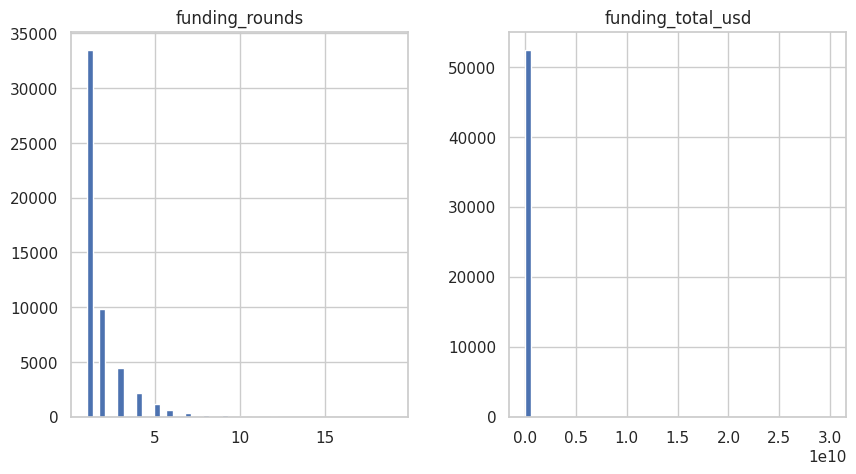

In [35]:
# Построим гистограммы для визуализации распределения числовых данных в тренировочной выборке
train_df[['funding_rounds', 'funding_total_usd']].hist(bins=50, figsize=(10, 5))
plt.show()

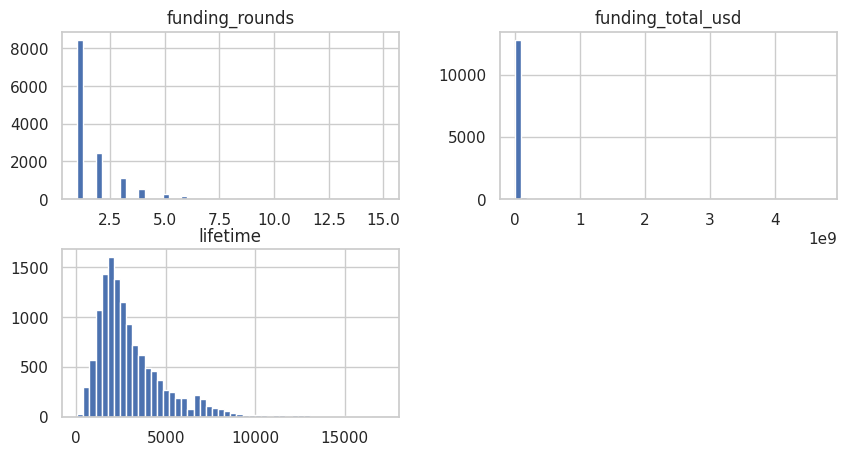

In [36]:
# Построим гистограммы для визуализации распределения числовых данных в тестовой выборке
test_df[['funding_rounds', 'funding_total_usd', 'lifetime']].hist(bins=50, figsize=(10, 5))
plt.show()

Гистограмма признака funding_total_usd говорит о наличие выбросов, проверим это ниже.

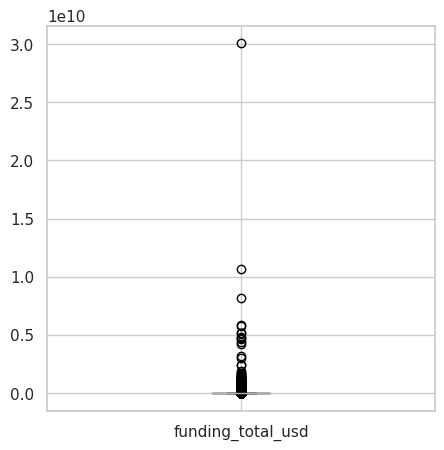

In [37]:
# Построим boxplot для визуализации распределения funding_total_usd в тренировочной выборке
train_df[['funding_total_usd']].boxplot(figsize=(5, 5))
plt.show()

В столбце присутствуют выбросы, но т.к. это финансовые данные и у нас нет возможности их верифицировать, оставим их в датасетах.

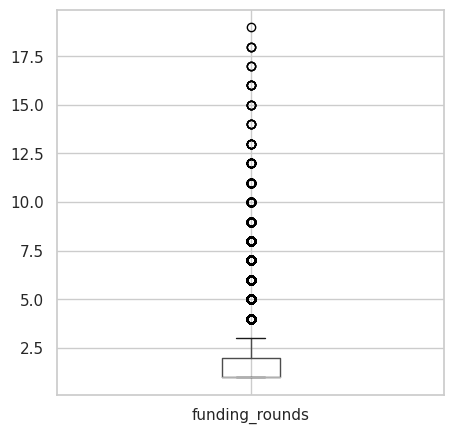

In [38]:
# Построим boxplot для визуализации распределения funding_rounds
train_df[['funding_rounds']].boxplot(figsize=(5, 5))
plt.show()

## Анализ категориальных признаков

In [39]:
# Расчитаем частоту для категориальных признаков: status, assigned_category, Country_Region
# Построим диаграммы для распределения значений по категориям
# 1. Расчет частоты для категориальных признаков
status_counts = train_df['status'].value_counts()
assigned_category_counts = train_df['assigned_category'].value_counts()
country_region_counts = train_df['Country_Region'].value_counts()

# Отображение частоты значений
print("Status Counts:")
print(status_counts)
print("\nAssigned Category Counts:")
print(assigned_category_counts)
print("\nCountry Region Counts:")
print(country_region_counts)

Status Counts:
status
operating    47599
closed        4917
Name: count, dtype: int64

Assigned Category Counts:
assigned_category
Technology and IT                      29086
Undefined                               3937
Real Business and Enterprises           3556
Social Networks and Communications      2427
Medicine and Healthcare                 2404
Consumer Goods and Retail               1523
Commerce and Trade                      1461
Entertainment and Media                 1351
Advertising and Marketing                894
Restaurant Business and Travel           818
Sports and Fitness                       744
Finance and Insurance                    728
Education                                705
Transport and Logistics                  615
Electronics and Hardware Technology      550
Real Estate and Architecture             400
Art and Creative Industries              335
Energy and Ecology                       298
Media and Publishing                     229
Mobile Technol

In [40]:
# Аналогично для тестовой выборки
assigned_category_counts = test_df['assigned_category'].value_counts()
country_region_counts = test_df['Country_Region'].value_counts()

# Отображение частоты значений
print("Status Counts:")
print(status_counts)
print("\nAssigned Category Counts:")
print(assigned_category_counts)
print("\nCountry Region Counts:")
print(country_region_counts)

Status Counts:
status
operating    47599
closed        4917
Name: count, dtype: int64

Assigned Category Counts:
assigned_category
Technology and IT                      7228
Undefined                               990
Real Business and Enterprises           934
Medicine and Healthcare                 612
Social Networks and Communications      582
Consumer Goods and Retail               379
Commerce and Trade                      377
Entertainment and Media                 341
Advertising and Marketing               216
Restaurant Business and Travel          205
Sports and Fitness                      195
Education                               187
Finance and Insurance                   184
Transport and Logistics                 157
Electronics and Hardware Technology     124
Real Estate and Architecture             93
Energy and Ecology                       90
Art and Creative Industries              67
Social and Personal Services             55
Media and Publishing             

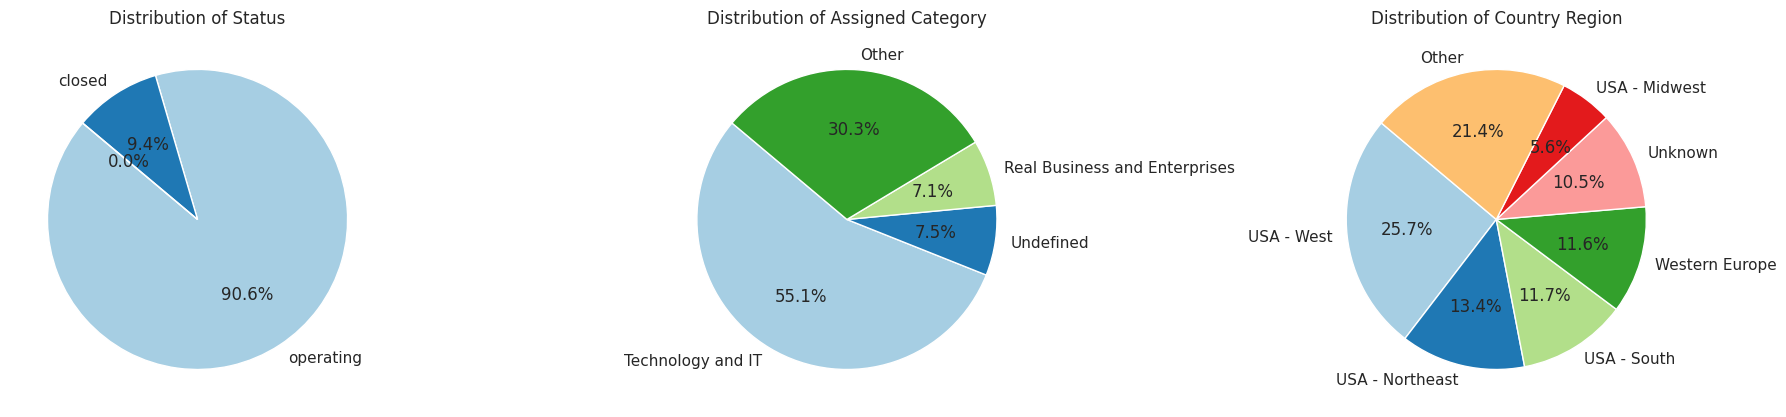

In [41]:
# Устанавливаем порог для редких категорий (например, если категория меньше 5% от общего числа)
threshold = 0.05

# Функция для объединения редких категорий
def group_small_categories(value_counts, threshold):
    total_count = value_counts.sum()
    grouped = value_counts[value_counts / total_count >= threshold]
    grouped['Other'] = value_counts[value_counts / total_count < threshold].sum()
    return grouped

# Применяем функцию к каждому признаку
status_counts_grouped = group_small_categories(status_counts, threshold)
assigned_category_counts_grouped = group_small_categories(assigned_category_counts, threshold)
country_region_counts_grouped = group_small_categories(country_region_counts, threshold)

# Построение круговых диаграмм с объединением редких категорий
plt.figure(figsize=(18, 6))

# Круговая диаграмма для status
plt.subplot(1, 3, 1)
status_counts_grouped.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Status')
plt.ylabel('')  # Убираем подпись оси для более чистого вида

# Круговая диаграмма для assigned_category
plt.subplot(1, 3, 2)
assigned_category_counts_grouped.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Assigned Category')
plt.ylabel('')

# Круговая диаграмма для Country_Region
plt.subplot(1, 3, 3)
country_region_counts_grouped.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Country Region')
plt.ylabel('')

plt.tight_layout()
plt.show()

1. Подавляющее большинство стартапов на момент среза данных продолжают деятельность.
2. Более половины стартапов занимаются технологическим бизнесом.
3. Регионы стартапов распределены более равномерно.

## Анализ временных признаков

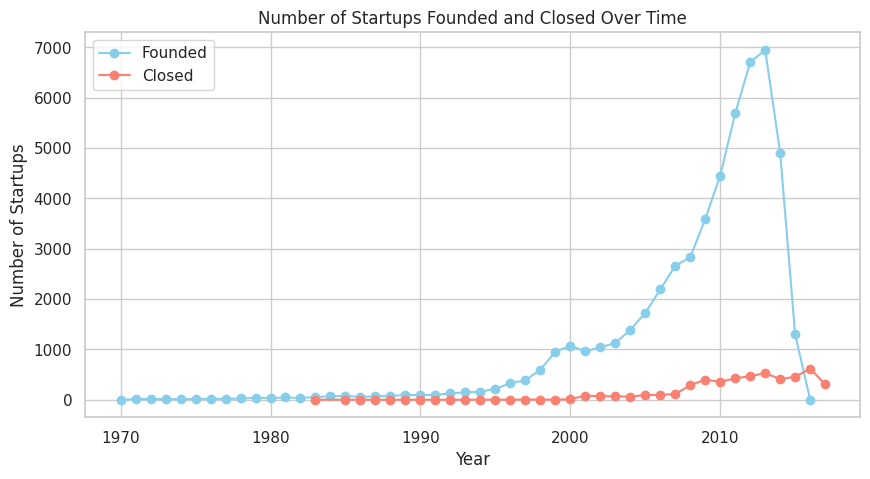

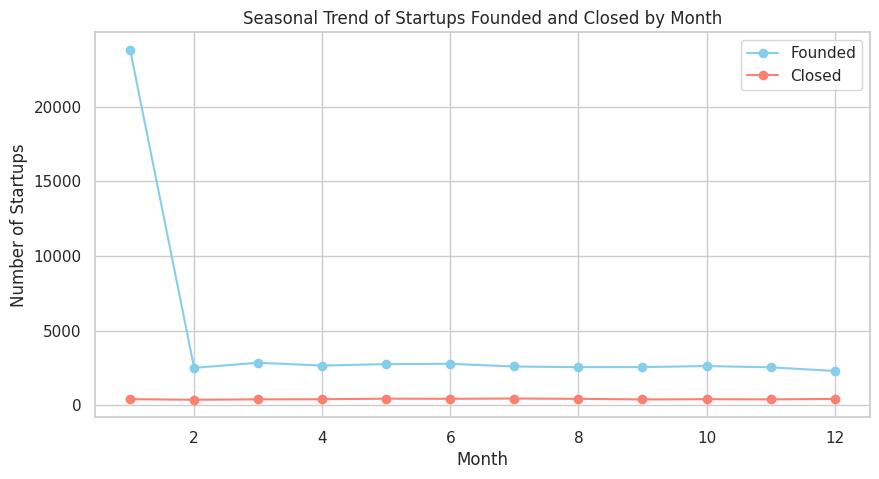

In [42]:
# 1. Агрегация данных по годам
# Группируем данные, считая количество стартапов, основанных и закрытых в каждом году
founded_counts = train_df['founded_at'].dt.year.value_counts().sort_index()
closed_counts = train_df['closed_at'].dt.year.value_counts().sort_index()

# 2. Построение графиков для анализа трендов
plt.figure(figsize=(10, 5))

# График для количества основанных стартапов по годам
plt.plot(founded_counts.index, founded_counts.values, marker='o', label='Founded', color='skyblue')
plt.plot(closed_counts.index, closed_counts.values, marker='o', label='Closed', color='salmon')

# Настройки графика
plt.title('Number of Startups Founded and Closed Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Startups')
plt.legend()
plt.grid(True)
plt.show()

# 3. Анализ сезонности (при необходимости)
# Если сезонность имеет значение, можно сгруппировать данные по месяцам или кварталам:
# Пример для группировки по месяцам
monthly_founded_counts = train_df['founded_at'].dt.month.value_counts().sort_index()
monthly_closed_counts = train_df['closed_at'].dt.month.value_counts().sort_index()

# Построение графиков для анализа сезонности
plt.figure(figsize=(10, 5))

plt.plot(monthly_founded_counts.index, monthly_founded_counts.values, marker='o', label='Founded', color='skyblue')
plt.plot(monthly_closed_counts.index, monthly_closed_counts.values, marker='o', label='Closed', color='salmon')

# Настройки графика
plt.title('Seasonal Trend of Startups Founded and Closed by Month')
plt.xlabel('Month')
plt.ylabel('Number of Startups')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
# Создаем DataFrames для удобного отображения
founded_df = pd.DataFrame({'Year': founded_counts.index, 'Founded Startups': founded_counts.values})

# Отображаем таблицы
print("Founded Startups by Year")
print(founded_df)

Founded Startups by Year
    Year  Founded Startups
0   1970                 2
1   1971                13
2   1972                17
3   1973                13
4   1974                11
5   1975                16
6   1976                20
7   1977                18
8   1978                26
9   1979                39
10  1980                34
11  1981                46
12  1982                37
13  1983                54
14  1984                72
15  1985                76
16  1986                57
17  1987                69
18  1988                78
19  1989                96
20  1990                95
21  1991                96
22  1992               129
23  1993               147
24  1994               162
25  1995               216
26  1996               332
27  1997               388
28  1998               598
29  1999               954
30  2000              1076
31  2001               961
32  2002              1045
33  2003              1128
34  2004              1389
35 

In [44]:
# Группировка данных: количество стартапов, основанных и закрытых в каждом месяце
founded_monthly_counts = train_df['founded_at'].dt.month.value_counts().sort_index()
closed_monthly_counts = train_df['closed_at'].dt.month.value_counts().sort_index()

# Создаем DataFrame для отображения сезонности
seasonality_df = pd.DataFrame({
    'Month': founded_monthly_counts.index,
    'Founded Startups': founded_monthly_counts.values,
    'Closed Startups': closed_monthly_counts.values
})

# Переименуем числовые значения месяцев в названия для удобства
seasonality_df['Month'] = seasonality_df['Month'].apply(lambda x: pd.to_datetime(str(x), format='%m').strftime('%B'))

# Отображаем таблицу
print("Seasonality of Founded and Closed Startups by Month")
print(seasonality_df)

Seasonality of Founded and Closed Startups by Month
        Month  Founded Startups  Closed Startups
0     January             23817              404
1    February              2505              367
2       March              2846              393
3       April              2657              401
4         May              2753              440
5        June              2775              432
6        July              2595              449
7      August              2551              429
8   September              2556              386
9     October              2625              403
10   November              2540              390
11   December              2296              423


1. Наблюдается существенное увеличение открытий стартапов с 2005 по 2014 г.г.
2. Сезонность отсутствует, но наблюдается существенное кол-во стартапов, открытых в январе, вероятно, это связано с отсутствием точных данных об открытии у множества стартапов.

# Разработка новых синтетических признаков
Добавим синтетические столбцы для более качественного анализа:
1. Продолжительность существования стартапа lifetime (для тренировочной выборки): Разница между датой основания и датой закрытия стартапа. Если стартап все еще активен, используем дату среза данных: 2018-01-01
2. Признаки финансирования:

  2.1. funding_rounds_per_year: Количество раундов финансирования, разделенное на количество лет существования стартапа.

  2.2. avg_funding_per_round: Средний объем финансирования за раунд (общая сумма финансирования, деленная на количество раундов).

3. Признаки, связанные со временем: founded_year (для тренировочной выборки): год основания
4. Бинарный признак, показывающий, получил ли стартап финансирование (если funding_total_usd > 0): is_funded
5. Логарифмированные признаки для финансирования
log_funding_total_usd: Преобразуем общий объем финансирования с помощью логарифма, чтобы уменьшить эффект выбросов.
6. Признаки для временных интервалов между раундами
avg_days_between_rounds: Среднее количество дней между раундами финансирования, если у стартапа было несколько раундов.
7. Из duration_days вычислим возраст стартапа и распределим по категориям (для тренировочной выборки).

P.S. Укрупненные признаки региона и рода деятельности были добавлены на предыдущих этапах.

In [45]:
# Устанавливаем дату среза данных для активных стартапов
cutoff_date = pd.Timestamp('2018-01-01')

# 1. Продолжительность существования стартапа
# Если стартап закрыт, считаем разницу между датами закрытия и основания; иначе - между текущей датой и основанием
train_df['lifetime'] = (train_df['closed_at'].fillna(cutoff_date) - train_df['founded_at']).dt.days

# 2. Признаки финансирования

# 2.1 funding_rounds_per_year: Количество раундов финансирования в год
# Для предотвращения деления на 0 заменяем нулевую продолжительность на минимальное значение 1 день
train_df['funding_rounds_per_year'] = train_df['funding_rounds'] / (train_df['lifetime'] / 365.25)
test_df['funding_rounds_per_year'] = test_df['funding_rounds'] / (test_df['lifetime'] / 365.25)

# 2.2 avg_funding_per_round: Среднее финансирование за раунд
train_df['avg_funding_per_round'] = train_df['funding_total_usd'] / train_df['funding_rounds']
test_df['avg_funding_per_round'] = test_df['funding_total_usd'] / test_df['funding_rounds']

# 3. Признаки, связанные со временем

# 3.1 founded_year: Год основания
train_df['founded_year'] = train_df['founded_at'].dt.year

# 4. Бинарный признак, показывающий, получил ли стартап финансирование
train_df['is_funded'] = (train_df['funding_total_usd'] > 0).astype(int)
test_df['is_funded'] = (test_df['funding_total_usd'] > 0).astype(int)

# 5. Логарифмированный признак для общего объема финансирования
# Используем log1p для обработки нулевых значений
train_df['log_funding_total_usd'] = np.log1p(train_df['funding_total_usd'])
test_df['log_funding_total_usd'] = np.log1p(test_df['funding_total_usd'])

# 6. Признак для среднего интервала между раундами финансирования
# Проверяем, что количество раундов больше одного для корректного расчета среднего интервала
train_df['avg_days_between_rounds'] = train_df['lifetime'] / train_df['funding_rounds']
test_df['avg_days_between_rounds'] = test_df['lifetime'] / test_df['funding_rounds']



In [46]:
# Определим функцию для преобразования количества дней в возрастные категории
def categorize_duration_days(days):
    if days < 365:
        return 'менее 1 года'
    elif 365 <= days < 3 * 365:
        return '1-3 года'
    elif 3 * 365 <= days < 7 * 365:
        return '4-7 лет'
    elif 7 * 365 <= days < 10 * 365:
        return '8-10 лет'
    elif 10 * 365 <= days < 15 * 365:
        return '10-15 лет'
    else:
        return 'более 15 лет'

# Применяем функцию к столбцу duration_days и создаем новый столбец age_category
train_df['age_category'] = train_df['lifetime'].apply(categorize_duration_days)
test_df['age_category'] = test_df['lifetime'].apply(categorize_duration_days)

train_df

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,assigned_category,Country_Region,lifetime,funding_rounds_per_year,avg_funding_per_round,founded_year,is_funded,log_funding_total_usd,avg_days_between_rounds,age_category
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,Restaurant Business and Travel,Western Europe,2998,0.243662,4.143130e+05,2009,1,13.627525,1499.000000,8-10 лет
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,Technology and IT,USA - West,4748,0.307709,1.073375e+07,2005,1,17.575198,1187.000000,10-15 лет
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,Technology and IT,USA - West,4383,0.250000,1.181879e+07,2006,1,17.383814,1461.000000,10-15 лет
3,Sancilio and Company,Health Care,22250000.0,operating,Unknown,Unknown,Unknown,Unknown,3,2004-01-01,...,Medicine and Healthcare,Unknown,5114,0.214265,7.416667e+06,2004,1,16.917853,1704.666667,10-15 лет
4,WireTough Cylinders,Manufacturing,2000000.0,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,Real Business and Enterprises,USA - South,2791,0.130867,2.000000e+06,2010,1,14.508658,2791.000000,8-10 лет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,2000000.0,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,...,Entertainment and Media,North America,2192,0.166629,2.000000e+06,2012,1,14.508658,2192.000000,4-7 лет
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,...,Restaurant Business and Travel,South Asia,1590,0.229717,5.000000e+05,2013,1,13.122365,1590.000000,4-7 лет
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,...,Technology and IT,USA - West,2741,0.399763,1.666667e+04,2010,1,10.819798,913.666667,8-10 лет
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,...,Undefined,USA - West,7336,0.298732,2.166667e+06,1997,1,16.380460,1222.666667,более 15 лет


In [47]:
test_df

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,assigned_category,Country_Region,funding_rounds_per_year,avg_funding_per_round,is_funded,log_funding_total_usd,avg_days_between_rounds,age_category
0,Crystalsol,Clean Technology,2819200.0,NIC,17,Unknown,Unknown,1,2011-05-01,2014-12-01,3501,Technology and IT,Central America,0.104327,2.819200e+06,1,14.851964,3501.000000,8-10 лет
1,JBI Fish & Wings,Hospitality,2000000.0,USA,TN,TN - Other,Humboldt,1,2010-05-04,2014-02-25,2717,Restaurant Business and Travel,USA - South,0.134431,2.000000e+06,1,14.508658,2717.000000,8-10 лет
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2012-08-20,2014-07-02,1295,Finance and Insurance,Eastern Europe,0.564093,2.141285e+05,1,12.967481,647.500000,4-7 лет
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2011-09-01,2014-07-18,4748,Technology and IT,USA - West,0.307709,8.675000e+06,1,17.362250,1187.000000,10-15 лет
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2012-02-01,2012-02-01,6209,Technology and IT,North America,0.058826,4.530000e+06,1,15.326233,6209.000000,более 15 лет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2000-03-31,2001-03-27,2267,Undefined,USA - West,0.161116,2.800000e+04,1,10.239996,2267.000000,4-7 лет
13121,GlobaTrek,Software,2000000.0,USA,CA,SF Bay Area,Mountain View,1,2012-08-17,2012-08-17,2192,Technology and IT,USA - West,0.166629,2.000000e+06,1,14.508658,2192.000000,4-7 лет
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2014-01-12,2014-01-12,2922,Commerce and Trade,USA - West,0.375000,1.866667e+06,1,15.538277,974.000000,8-10 лет
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2015-04-20,2015-04-20,1386,Technology and IT,USA - Northeast,0.527056,7.500000e+04,1,11.918397,693.000000,4-7 лет


In [48]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   name                     52516 non-null  object        
 1   category_list            52516 non-null  object        
 2   funding_total_usd        52516 non-null  float64       
 3   status                   52516 non-null  object        
 4   country_code             52516 non-null  object        
 5   state_code               52516 non-null  object        
 6   region                   52516 non-null  object        
 7   city                     52516 non-null  object        
 8   funding_rounds           52516 non-null  int64         
 9   founded_at               52516 non-null  datetime64[ns]
 10  first_funding_at         52516 non-null  datetime64[ns]
 11  last_funding_at          52516 non-null  datetime64[ns]
 12  closed_at                4917 no

In [49]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   name                     13125 non-null  object        
 1   category_list            13125 non-null  object        
 2   funding_total_usd        13125 non-null  float64       
 3   country_code             13125 non-null  object        
 4   state_code               13125 non-null  object        
 5   region                   13125 non-null  object        
 6   city                     13125 non-null  object        
 7   funding_rounds           13125 non-null  int64         
 8   first_funding_at         13125 non-null  datetime64[ns]
 9   last_funding_at          13125 non-null  datetime64[ns]
 10  lifetime                 13125 non-null  int64         
 11  assigned_category        13125 non-null  object        
 12  Country_Region           13125 n

In [50]:
# Столбец is_funded переведем в object
train_df['is_funded'] = train_df['is_funded'].astype('object')
test_df['is_funded'] = test_df['is_funded'].astype('object')

# Столбец founded_year переведем в object
train_df['founded_year'] = train_df['founded_year'].astype('object')

# Столбец funding_rounds переведем в object
train_df['funding_rounds'] = train_df['funding_rounds'].astype('object')
test_df['funding_rounds'] = test_df['funding_rounds'].astype('object')

# Проверка на мультиколлинеарность

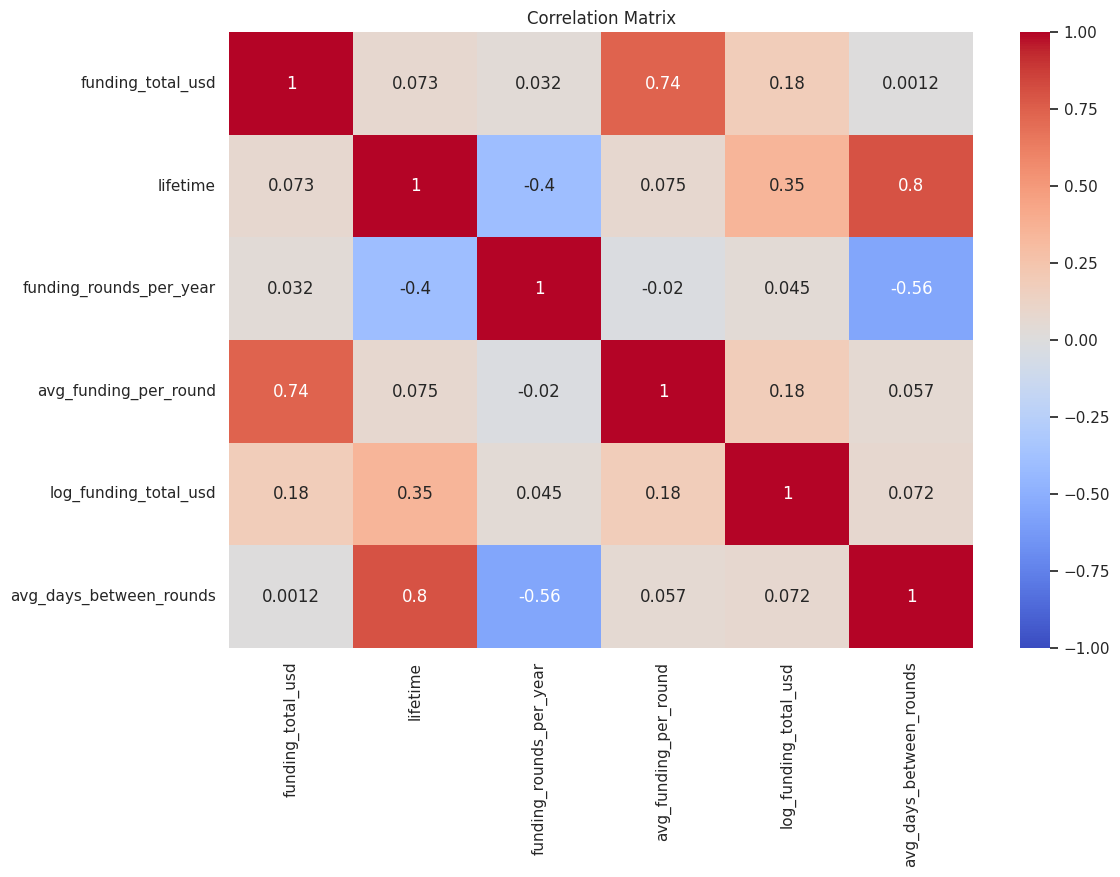

                   Feature        VIF
0        funding_total_usd   2.286161
1                 lifetime  10.129568
2  funding_rounds_per_year   3.276290
3    avg_funding_per_round   2.275036
4    log_funding_total_usd   8.187318
5  avg_days_between_rounds   7.644277


In [51]:
# 1. Корреляционная матрица
# Выбираем числовые признаки для анализа мультиколлинеарности
numeric_features = train_df.select_dtypes(include=[np.number])

# Построение корреляционной матрицы
corr_matrix = numeric_features.corr()

# Визуализация корреляционной матрицы с помощью тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# 2. Расчет факторов инфляции дисперсии (VIF)
# Создаем DataFrame для хранения значений VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_features.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_features.values, i) for i in range(numeric_features.shape[1])]

# Отображаем результат
print(vif_data)

Судя по значениям VIF, некоторые признаки демонстрируют высокую мультиколлинеарность, что может негативно повлиять на модель. Попробуем не использовать lifetime.

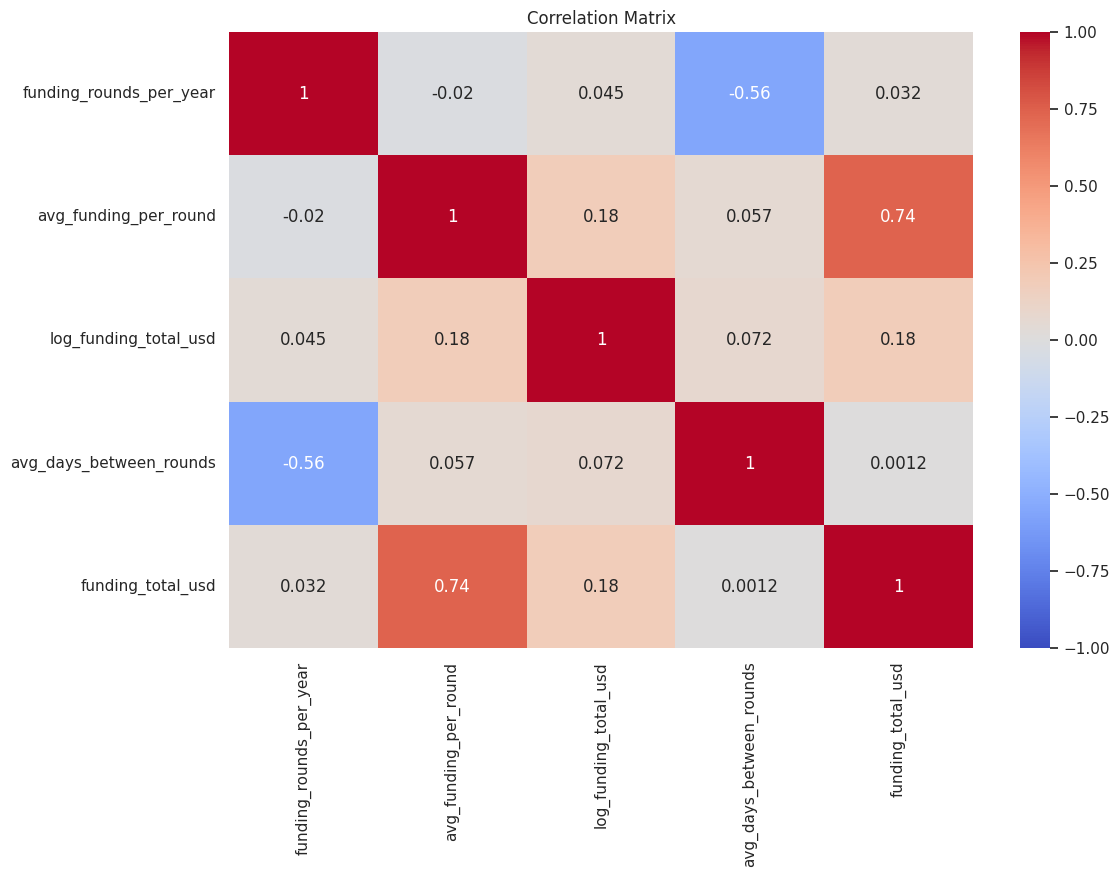

                   Feature       VIF
0  funding_rounds_per_year  3.272644
1    avg_funding_per_round  2.262625
2    log_funding_total_usd  6.841912
3  avg_days_between_rounds  3.345388
4        funding_total_usd  2.254523


In [52]:
# 1. Корреляционная матрица
# Выбираем числовые признаки для анализа мультиколлинеарности
numeric_features = train_df[['funding_rounds_per_year', 'avg_funding_per_round', 'log_funding_total_usd', 'avg_days_between_rounds', 'funding_total_usd']]

# Построение корреляционной матрицы
corr_matrix = numeric_features.corr()

# Визуализация корреляционной матрицы с помощью тепловой карты
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# 2. Расчет факторов инфляции дисперсии (VIF)
# Создаем DataFrame для хранения значений VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_features.columns
vif_data['VIF'] = [variance_inflation_factor(numeric_features.values, i) for i in range(numeric_features.shape[1])]

# Отображаем результат
print(vif_data)

С текущими значениями VIF признаки демонстрируют допустимый уровень мультиколлинеарности. Вот что означают полученные значения:

funding_rounds_per_year (VIF ≈ 3.27),
avg_days_between_rounds (VIF ≈ 3.35),
funding_total_usd (VIF ≈ 2.25) и avg_funding_per_round (VIF ≈ 2.26): Эти признаки имеют VIF ниже 5, что указывает на низкий уровень мультиколлинеарности. Они могут использоваться в модели без риска значительной корреляции.

log_funding_total_usd (VIF ≈ 6.84): Несмотря на то что это значение выше остальных, оно остается в допустимых пределах и обеспечивает информацию о финансировании с уменьшенным эффектом выбросов.

# Отбор и подготовка финального набора обучающих признаков

In [53]:
# Определяем, какие категориальные признаки использовать с One-Hot и Label Encoding
ohe_features = ['assigned_category', 'age_category', 'is_funded']
label_features = ['Country_Region', 'funding_rounds']

# Числовые признаки
numerical_features = ['funding_total_usd', 'lifetime', 'funding_rounds_per_year',
                      'avg_funding_per_round', 'log_funding_total_usd', 'avg_days_between_rounds']

# Пайплайн для категориальных признаков (One-Hot Encoding)
ohe_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Пайплайн для категориальных признаков (Label Encoding)
label_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label_encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Пайплайн для числовых данных
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Колонный трансформер для обработки всех данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('ohe', ohe_transformer, ohe_features),
        ('label', label_transformer, label_features)
    ])

# Разделение на обучающую и тестовую выборки
X = train_df.drop(['status', 'name', 'region', 'city', 'category_list', 'country_code', 'state_code'], axis=1)
y = train_df['status']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Применение предобработки
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)

Финальный набор признаков для обучения после предобработки включает:

Числовые признаки:

funding_total_usd: общая сумма финансирования в долларах США.

lifetime: продолжительность жизни стартапа.

funding_rounds_per_year: среднее количество раундов финансирования в год.

avg_funding_per_round: средняя сумма финансирования на один раунд.

log_funding_total_usd: логарифм общей суммы финансирования.

avg_days_between_rounds: среднее количество дней между раундами финансирования.


Категориальные признаки (с применением кодирования):

One-Hot Encoding:

assigned_category: назначенная категория стартапа.

age_category: возрастная категория стартапа.

is_funded: бинарный признак, показывающий, был ли стартап профинансирован.

Label Encoding:

Country_Region: страна и регион.

funding_rounds: количество раундов финансирования (обработанный как категориальный).

После предобработки признаки One-Hot Encoding будут представлены несколькими бинарными столбцами (по одному на каждую категорию), тогда как признаки Label Encoding будут представлены числовыми значениями, что дает итоговую таблицу признаков с расширенными категориальными столбцами.

# Выбор и обучение моделей

In [54]:
# Словарь моделей для тестирования
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Словарь для хранения результатов
results = {}
best_model = None
best_f1_score = 0

# Обучение каждой модели и оценка F1 Score на валидационном наборе
for model_name, model in models.items():
    print(f"Обучение модели {model_name}...")
    model.fit(X_train, y_train)

    # Предсказания и расчет F1 Score на валидационной выборке
    y_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_pred, average='weighted')
    results[model_name] = f1  # Сохраняем результат
    print(f"{model_name}: F1 Score = {f1:.4f}")

    # Сохранение модели, если F1 Score выше предыдущего лучшего результата
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model = model
        joblib.dump(best_model, 'best_model.pkl')  # Сохраняем лучшую модель

# Сортировка и отображение рейтинга моделей по F1 Score
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print("\nРейтинг моделей по F1 Score:")
for rank, (model_name, f1) in enumerate(sorted_results, start=1):
    print(f"{rank}. {model_name}: F1 Score = {f1:.4f}")

print(f"\nЛучшая модель: {best_model} с F1 Score = {best_f1_score:.4f}")

Обучение модели Logistic Regression...
Logistic Regression: F1 Score = 0.9462
Обучение модели Decision Tree...
Decision Tree: F1 Score = 0.9311
Обучение модели Random Forest...
Random Forest: F1 Score = 0.9486
Обучение модели Gradient Boosting...
Gradient Boosting: F1 Score = 0.9520
Обучение модели LightGBM...
[LightGBM] [Info] Number of positive: 38078, number of negative: 3934
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1656
[LightGBM] [Info] Number of data points in the train set: 42012, number of used features: 69
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.906360 -> initscore=2.269980
[LightGBM] [Info] Start training from score 2.269980
LightGBM: F1 Score = 0.9519

Рейтинг моделей по F1 Score:
1. Gradient Boosting: F1 Score = 0.9520
2. LightGBM: F1 Score = 0.9519
3. Random Forest: F1 Score = 0.9486
4. Logistic Regression: F1 Score

Результаты сравнения моделей по метрике F1 показали, что лучшими моделями являются:

1. Gradient Boosting с F1 Score = 0.9520
2. LightGBM с F1 Score = 0.9519
3. Random Forest с F1 Score = 0.9486

Эти модели продемонстрировали высокий F1 Score и могут быть рассмотрены для финального выбора. Также была попытка подбора гиперпараметров для данных моделей и оценка по кросс-валидации, но результат не оказался ощутимо лучше, чем при стандартных настройках.

Не предоставляю данный код здесь по причине очень долгого его выполнения системой.

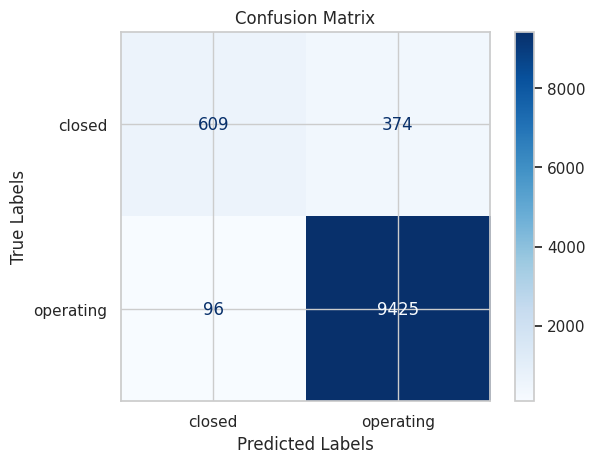

In [58]:
# Построение матрицы ошибок
cm = confusion_matrix(y_val, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

На предоставленной матрице ошибок можно видеть следующие результаты:

True Negatives (TN): 609 — модель правильно предсказала отрицательный класс.

False Positives (FP): 374 — модель ошибочно предсказала положительный класс, когда на самом деле класс был отрицательным.

False Negatives (FN): 96 — модель ошибочно предсказала отрицательный класс, когда на самом деле класс был положительным.

True Positives (TP): 9425 — модель правильно предсказала положительный класс.

Эта матрица ошибок демонстрирует, что модель имеет отличные результаты, с минимальным количеством ошибок как для положительного, так и для отрицательного классов. Это хороший показатель того, что модель хорошо справляется с задачей классификации в данном случае.

# Анализ важности признаков лучшей модели

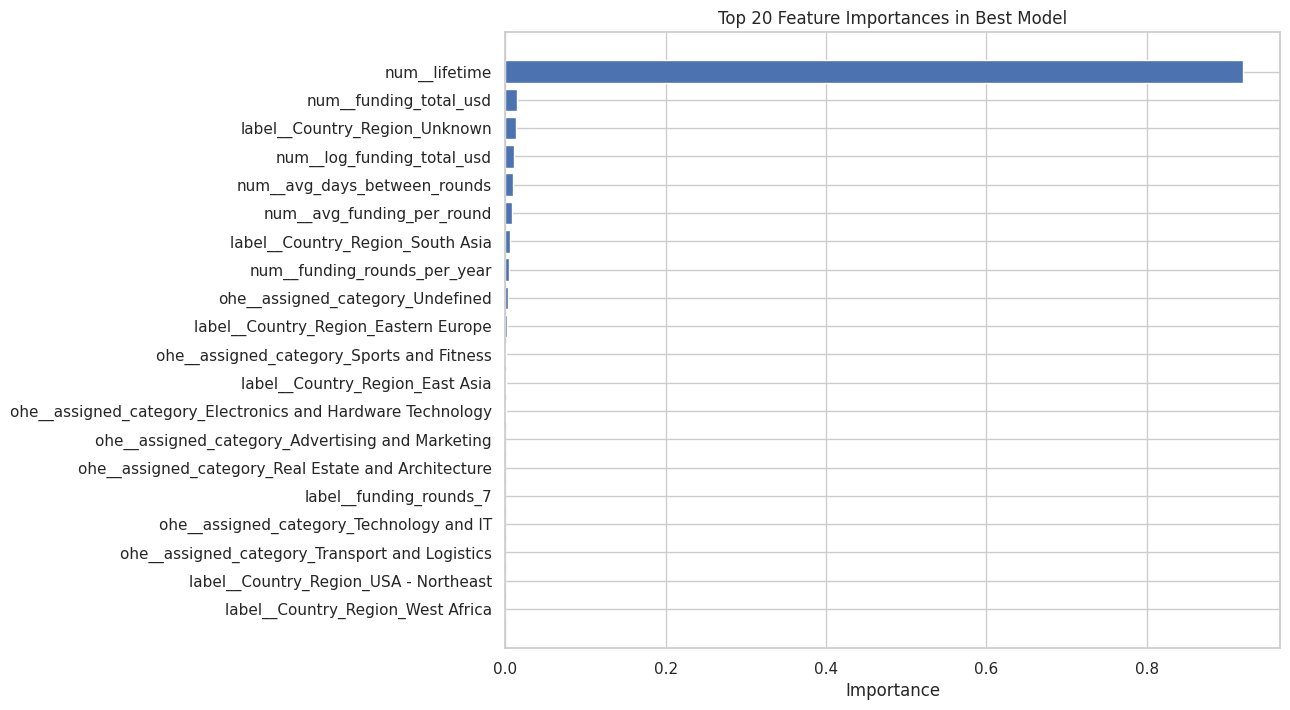

In [61]:
# Проверка, поддерживает ли лучшая модель атрибут feature_importances_
if hasattr(best_model, "feature_importances_"):
    # Получение важности признаков
    feature_importances = best_model.feature_importances_

    # Получение имен признаков после предобработки
    feature_names = preprocessor.get_feature_names_out()

    # Создание DataFrame для упорядочивания признаков по важности
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Получаем DataFrame только с 10–20 наиболее важными признаками
    top_features = feature_importance_df.head(20)

# Визуализация важности только этих признаков
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel("Importance")
plt.title("Top 20 Feature Importances in Best Model")
plt.gca().invert_yaxis()  # Важные признаки сверху
plt.show()

Эти результаты указывают на то, что наиболее значимым фактором является lifetime, который значительно влияет на вероятность закрытия стартапа. Прочие признаки не так важны.

# Генерация предсказаний в тестовый датасет и загрузка в Kaggle

In [55]:
# Загрузка лучшей модели, ранее сохраненной в 'best_model.pkl'
best_model = joblib.load('best_model.pkl')

# Загрузка тестового набора данных
# Преобразование столбцов с датами в числовые значения в test_df
X_test = test_df.drop(['name', 'category_list', 'country_code', 'state_code', 'region', 'city'], axis=1).copy()

# Преобразуем даты в количество дней с минимальной даты в каждом столбце
date_columns = X_test.select_dtypes(include=['datetime']).columns
for col in date_columns:
    X_test[col] = (X_test[col] - X_test[col].min()).dt.days

# Применение ранее обученного ColumnTransformer 'preprocessor' к тестовому набору
X_test = preprocessor.transform(X_test)

# Предсказания на тестовом наборе
y_test_pred = best_model.predict(X_test)

# Создание DataFrame для финального файла предсказаний
submission = pd.DataFrame({
    'name': test_df['name'],
    'status': y_test_pred
})

# Сохранение предсказаний в CSV файл для загрузки на Kaggle
submission.to_csv('kaggle_startups_submission.csv', index=False)

In [56]:
submission = pd.read_csv('kaggle_startups_submission.csv')
submission

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating


In [57]:
# Посчитаем кол-во строк для каждого значения status
submission['status'].value_counts()

,count
status,
operating,12211
closed,914


# Отчет по исследованию

## Введение

Проект посвящен анализу и предсказанию закрытия стартапов на основе различных характеристик и метрик, таких как общее финансирование, продолжительность, количество раундов финансирования и категория стартапа. Данные охватывают период с 1970 по 2018 год, что позволяет изучить, какие факторы наиболее сильно влияют на жизнеспособность стартапов.

## Цель исследования
Целью исследования является построение модели, которая сможет предсказывать статус стартапа (operating или closed), используя набор признаков, включающих как числовые, так и категориальные данные.

## Предобработка данных
В ходе предобработки данных мы проделали следующие шаги:

  1. Удаление ненужных столбцов: Убрали столбцы, такие как name, region, city, category_list, country_code, state_code, поскольку они не добавляют ценности для предсказания.
  2. Изменили типы данных, где это необходимо.
  3. Заполнили пропуски.
  4. Избавились от неявных дубликатов путем применения словарей.

## Обработка категориальных признаков:

Для признаков с небольшим количеством уникальных значений использовали One-Hot Encoding (например, assigned_category, age_category, is_funded).

Для признаков с большим количеством уникальных значений использовали Label Encoding (например, Country_Region, funding_rounds).

## Обработка числовых данных:

Пропущенные значения заполнялись медианным значением по столбцу.

Данные были нормализованы с использованием StandardScaler для выравнивания распределения признаков.

## Обучение моделей
Были протестированы несколько моделей машинного обучения:

  1. Логистическая регрессия
  2. Дерево решений
  3. Случайный лес
  4. Градиентный бустинг
  5. LightGBM

Каждая модель была обучена на тренировочном наборе данных, и для оценки качества предсказаний использовался F1 Score на валидационном наборе. Модель с наивысшим F1 Score была выбрана как лучшая и сохранена для дальнейших предсказаний.

## Рейтинг моделей
По результатам F1 Score был построен рейтинг моделей. Лучшая модель оказалась Gradient Boosting с F1 Score = 0.9520.

## Анализ важности признаков
Для лучшей модели был проведен анализ важности признаков. Наиболее важным признаком оказался lifetime.

## Заключение

Результаты исследования показали, что выбранная модель способна достаточно точно предсказывать статус стартапа на основе предоставленных признаков. Наибольшее влияние на предсказания модели оказывает lifetime, что совпадает с интуитивными ожиданиями.

## Рекомендации

  1. Провести более глубокий анализ факторов, влияющих на важные признаки.
  2. Рассмотреть возможность добавления временных признаков (например, возраст стартапа на момент последнего финансирования).
  3. Применить подбор гиперпараметров для улучшения качества модели.
  4. Рассмотреть применение других методов интерпретации модели, таких как SHAP или Permutation Importance, для более детального анализа влияния признаков.